## Let's create a dataset by downloading images from Bing

### Generate a dataframe from the downloaded images

In [18]:
import os
import pandas as pd

QUERIES = ["cpp", "hs", "py"]
directory = "./raw_data/img/cropped_224"
data = []
label = ""
for file in os.listdir(directory):
    if(file.startswith("cpp")):
        label = "cpp"
    elif(file.startswith("hs")):
        label = "hs"
    elif(file.startswith("py")):
        label = "py"    
    
    data.append([os.path.join(directory, file), label])
dataframe = pd.DataFrame(data, columns=["path", "label"])
print(dataframe)

                                      path label
0      ./raw_data/img/cropped_224\cpp1.png   cpp
1     ./raw_data/img/cropped_224\cpp10.png   cpp
2    ./raw_data/img/cropped_224\cpp100.png   cpp
3     ./raw_data/img/cropped_224\cpp11.png   cpp
4     ./raw_data/img/cropped_224\cpp12.png   cpp
..                                     ...   ...
295    ./raw_data/img/cropped_224\py95.png    py
296    ./raw_data/img/cropped_224\py96.png    py
297    ./raw_data/img/cropped_224\py97.png    py
298    ./raw_data/img/cropped_224\py98.png    py
299    ./raw_data/img/cropped_224\py99.png    py

[300 rows x 2 columns]


### Show some images of the dataset

In [19]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in dataframe.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Fetch MobileNetV2 model

In [ ]:
import tensorflow
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False # We don't want to include the fully-connected layers
)

In [ ]:
# You can see the list of layers of this model
base_model.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=Conv1, built=True>,
 <BatchNormalization name=bn_Conv1, built=True>,
 <ReLU name=Conv1_relu, built=True>,
 <DepthwiseConv2D name=expanded_conv_depthwise, built=True>,
 <BatchNormalization name=expanded_conv_depthwise_BN, built=True>,
 <ReLU name=expanded_conv_depthwise_relu, built=True>,
 <Conv2D name=expanded_conv_project, built=True>,
 <BatchNormalization name=expanded_conv_project_BN, built=True>,
 <Conv2D name=block_1_expand, built=True>,
 <BatchNormalization name=block_1_expand_BN, built=True>,
 <ReLU name=block_1_expand_relu, built=True>,
 <ZeroPadding2D name=block_1_pad, built=True>,
 <DepthwiseConv2D name=block_1_depthwise, built=True>,
 <BatchNormalization name=block_1_depthwise_BN, built=True>,
 <ReLU name=block_1_depthwise_relu, built=True>,
 <Conv2D name=block_1_project, built=True>,
 <BatchNormalization name=block_1_project_BN, built=True>,
 <Conv2D name=block_2_expand, built=True>,
 <BatchNormalization name=block_2

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)

def get_model():
    # We want to add layers on top of the base (here MobileNetV2) model
    layers = base_model.output

    # We need to flatten
    layers = Flatten()(layers)
    #layers = GlobalAveragePooling2D()(layers)


     # Add dense layers with batch normalization and dropout
    layers = Dense(48, activation='relu')(layers)
    layers = Dropout(0.2)(layers)
    layers = Dense(48, activation='relu')(layers)
    layers = Dropout(0.2)(layers)
    
    # layers = Dense(128, activation='relu')(layers)
    # layers = Dropout(0.5)(layers)
    # We must add an output layer
    output = Dense(len(QUERIES), activation='softmax')(layers) # final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=output)

    #Freeze the base model
    for layer in base_model.layers:
      layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    # Dégeler quelques couches du modèle de base et continuer l'entraînement
    # for layer in base_model.layers[-10:]:
    #   layer.trainable = True
    
    model.compile(
      optimizer = Adam(learning_rate=0.0001),
      # Sparse categorical crossentropy is used when we have target class as integers
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [ ]:
get_model().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 5,271,091 (20.11 MB)

 Trainable params: 3,733,107 (14.24 MB)

 Non-trainable params: 1,537,984 (5.87 MB)

## Cross validate model

In [ ]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

In [ ]:
def open_images(paths):
    images = []
    for path in paths:
        with PIL.Image.open(path).convert('RGB') as image:
            images.append(image_preprocesses(np.asarray(image)))
            
    return np.stack(images)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = dataframe.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 6

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=16,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 452ms/step - acc: 0.2856 - loss: 2.0579 - val_acc: 0.2708 - val_loss: 1.1425
Epoch 2/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - acc: 0.4636 - loss: 1.4048 - val_acc: 0.2917 - val_loss: 1.1097
Epoch 3/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 336ms/step - acc: 0.4105 - loss: 1.2192 - val_acc: 0.5208 - val_loss: 1.0734
Epoch 4/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - acc: 0.4764 - loss: 1.1867 - val_acc: 0.4792 - val_loss: 1.0745
Epoch 5/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - acc: 0.4629 - loss: 1.0194 - val_acc: 0.5417 - val_loss: 1.0638
Epoch 6/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step - acc: 0.4366 - loss: 1.0875 - val_acc: 0.5000 - val_loss: 1.0615
Epoch 1/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - acc: 0.3202 - loss: 1.8289 - val_acc: 0.3125 - val_loss: 1.1937
Epoch 2/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - acc: 0.4002 - loss: 1.3570 - val_acc: 0.2917 - val_loss: 1.1418
Epoch 3/6
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - acc: 0.51

In [ ]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


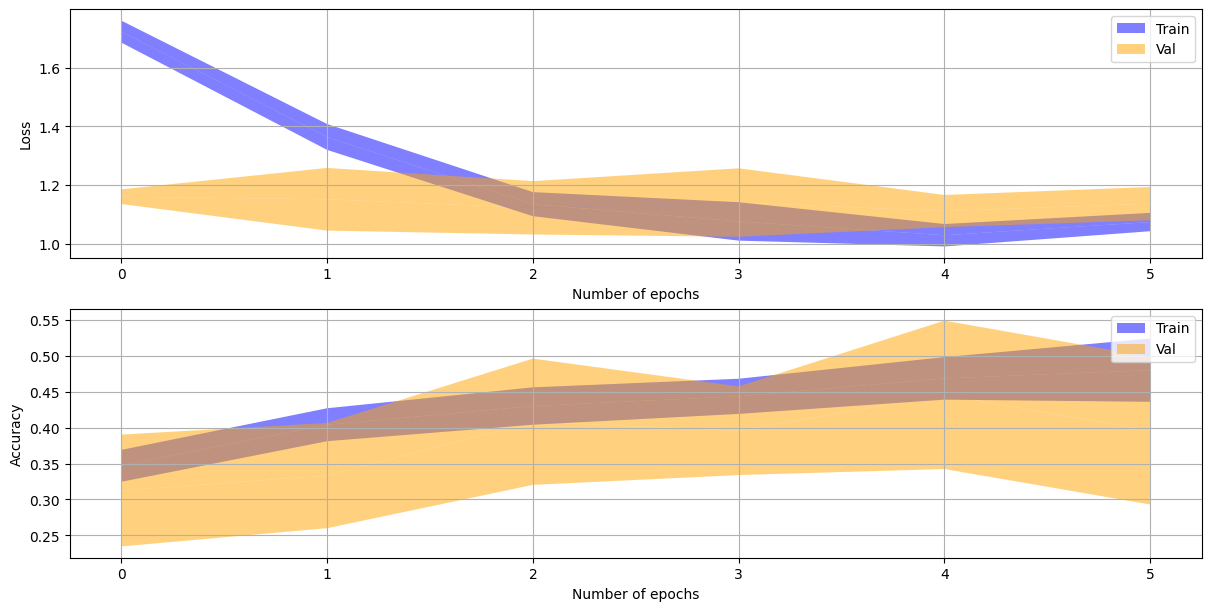

In [ ]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

In [ ]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)    
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=16,
    epochs=NB_EPOCHS,
)

Epoch 1/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - acc: 0.3477 - loss: 1.4822
Epoch 2/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - acc: 0.4738 - loss: 1.1507
Epoch 3/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - acc: 0.4557 - loss: 1.0347
Epoch 4/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - acc: 0.4637 - loss: 0.9460
Epoch 5/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - acc: 0.5273 - loss: 0.9254
Epoch 6/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - acc: 0.5637 - loss: 0.9323


In [ ]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

62632

In [ ]:
import sklearn.metrics as me
test_images = open_images(test_paths)    

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(QUERIES)))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


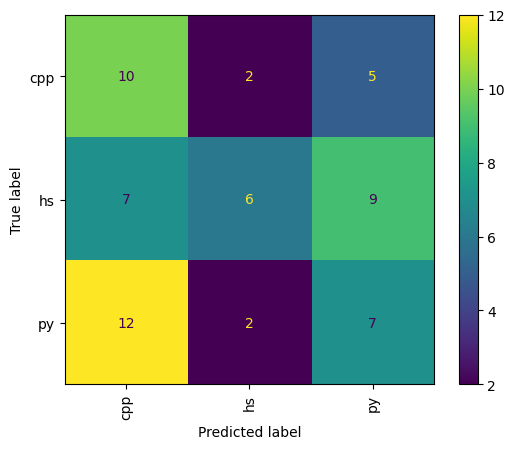

In [ ]:
confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=QUERIES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()

# GRAD-CAM HEATMAP

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Pool the gradients over all the axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weigh the output feature map of the last conv layer with the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Apply ReLU to the heatmap (eliminate negative values)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def display_heatmap(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")
    
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)
    
    # Display the superimposed image
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

C:\Users\Eyrag\AppData\Local\Temp\ipykernel_10256\823560287.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


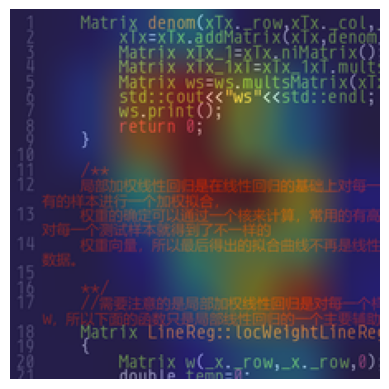

In [ ]:
# Path to the image to be visualized
img_path = 'E:/Project/HEIG_ARN_Projet/raw_data/img/cropped_224/cpp34.png'

# Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Generate heatmap
last_conv_layer_name = "Conv_1_bn"  # This may change based on your model architecture
heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
display_heatmap(img_path, heatmap)